# Anomaly Detection in OpenShift Deployments

In this notebook, we'll demonstrate how to query and aggregate any arbitrary set of configuration and health related prometheus metrics collected from CI/CD OpenShift deployments, using libraries built by the AI Ops team. Then, we will massage these metrics into a pandas dataframe, so that this data can easily be used for data science tasks. Finally, we will apply anomaly detection models to see if there are any OpenShift deployments in the fleet that are behaving anomalously, and therefore need SME attention.

At this early stage, we are also giving specific attention to the means of validation: using alerts and failures as a proxy for the performance of models. Which is to say, the anomaly detection work below is very preliminary and here to show the kinds of detection tools that can be used, but we would like feedback on the validation approach before digging any deeper into the ML models themselves.

In this notebook specifically, we are implementing anomaly detection; but in general this workflow can be used for complex analysis, reporting and ingestion into any machine learning algorithm.

For this notebook, we'll use data from CI/CD deployments *only*, because production customer data cannot be exposed publicly.

In [1]:
# imports
import datetime as dt

import ipywidgets as widgets
from IPython.display import display

import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import interp2d

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import PowerTransformer

import shap

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from prometheus_api_client import PrometheusConnect

from src.data.utils import prom_query_to_df_cached
from src.models.evaluate import validate_by_alertsdf, validate_by_failingdf

sns.set()

## Data Access (only needed if _not_ using sample data)

In this section, we will configure access to the prometheus metrics that will be used for anomaly detection. In the following cell, set the value of `PROM_URL` to the url of the prometheus instance you want to query. Set the value of `PROM_ACCESS_TOKEN` to the bearer token for authentication.

**NOTE:** If you are internal to Red Hat, you might be able to request access to the DataHub prometheus instance (https://telemeter-lts.datahub.redhat.com/).

In [2]:
# prometheus from which metrics are to be fetched
PROM_URL = "https://telemeter-lts.datahub.redhat.com/"
PROM_ACCESS_TOKEN = "your_token_here"

In [3]:
# prom connector does the "talking to prometheus" part of the nb, facilitates
# data (prometheus metrics) fetching
pc = PrometheusConnect(
    url=PROM_URL,
    disable_ssl=True,
    headers={"Authorization": f"bearer {PROM_ACCESS_TOKEN}"},
)

### Set Evaluation Timestamp
Use the widget in the output of the following cell to set the timestamp from which metrics are fetched.
The timestamp is `year=2020, month=7, day=31`, since we observed the most CI deployments data on this date.

In [4]:
# set time from which to get data
def set_qet(year, month, day, hour, minute, second):
    global query_eval_time, query_eval_timestamp
    query_eval_time = dt.datetime(
        year=year,
        month=month,
        day=day,
        hour=hour,
        minute=minute,
        second=second,
        tzinfo=dt.timezone.utc,
    )
    query_eval_timestamp = query_eval_time.timestamp()


# widget to set query evaluation timestamp
display(
    widgets.interactive(
        set_qet,
        year=widgets.Dropdown(options=range(2020, 2010, -1), value=2020),
        month=widgets.Dropdown(options=range(1, 13), value=7),
        day=widgets.Dropdown(options=range(1, 32), value=31),
        hour=widgets.Dropdown(options=range(24)),
        minute=widgets.Dropdown(options=range(60)),
        second=widgets.Dropdown(options=range(60)),
    )
)

interactive(children=(Dropdown(description='year', options=(2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 20…

### Determine Which Deployments are CICD

For this demo notebook, we are going to look at the data coming from CI/CD deployments only. So first we'll read in the `_id`s of deployments we're interested in. Then we'll ensure that the promql queries used in the following cells are set to collect data from these `id`s only.

**NOTE:** If you do not want filter by any specific `id`s, then you can simple set `cids_filter = ".+"` in the cell below.

In [5]:
# get information to identifies which deployments are cicd
cicd_ids_df = pd.read_parquet(
    "../../data/raw/19b850f367e32687057f193ff222707c"
)

# create regex to add to promql such that only data from these cicd
# deployment ids are fetched
cids_filter = "|".join(cid for cid in cicd_ids_df.index.unique())

print(cicd_ids_df.shape)
cicd_ids_df.head()

(134, 2)


,invoker,timestamp
_id,,
227cafd3-af0d-4a4f-a1bf-ec8e5aff1a91,openshift-internal-ci/pull-ci-openshift-cluste...,1596153600
d5909c3b-6925-4cdf-ab1a-8b91aab7a1dc,openshift-internal-ci/pull-ci-openshift-instal...,1596153600
deb496c1-1c9d-4b4e-8035-2f538f86786b,openshift-internal-ci/rehearse-8108-pull-ci-op...,1596153600
f13c81d2-6488-4200-ae59-3717b4621793,openshift-internal-ci/pull-ci-openshift-consol...,1596153600
1ca8edfb-022f-4b3e-98cd-299e066a66c8,openshift-internal-ci/pull-ci-openshift-knativ...,1596153600


## Collect Metrics used as Features

In this section, we will fetch the metrics that will be used as "features", i.e. model inputs, for the anomaly detection models.

### Metrics with Exactly One Value per Deployment

Some prometheus metrics, e.g. `cluster:cpu_usage_cores:sum`, have exactly one value for each deployment. This is the simpler case of two (a metric could have multiple values for a given deployment, as we'll see [later](#Metrics-with-Multiple-Values-for-the-Same-Deployment)). For this case, we can just fetch that metric value and then add it as a column to our dataset.

In [6]:
# cpu usage
feat = f'cluster:cpu_usage_cores:sum{{_id=~"{cids_filter}"}}'
usg_cores_df = prom_query_to_df_cached(
    pc,
    promql=f"max by (_id) ({feat})",
    metric_type="numeric",
    keepcols=["_id", "value"],
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
)
usg_cores_df = usg_cores_df.rename(
    columns={"value": f'{feat[:feat.find("{")]}'}
)
print(usg_cores_df.shape)

using cache 0ac51252375d46c58442ae319bc0aabd
(124, 1)


In [7]:
# memory usage
feat = f'cluster:memory_usage_bytes:sum{{_id=~"{cids_filter}"}}'
usg_mem_df = prom_query_to_df_cached(
    pc,
    promql=f"max by (_id) ({feat})",
    metric_type="numeric",
    keepcols=["_id", "value"],
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
)
usg_mem_df = usg_mem_df.rename(columns={"value": f'{feat[:feat.find("{")]}'})
print(usg_mem_df.shape)

using cache c2db364c1921fe15ce8b1a3a7e828ed1
(127, 1)


In [8]:
# openshift cpu usage
feat = f'openshift:cpu_usage_cores:sum{{_id=~"{cids_filter}"}}'
ocp_usg_cores_df = prom_query_to_df_cached(
    pc,
    promql=f"max by (_id) ({feat})",
    metric_type="numeric",
    keepcols=["_id", "value"],
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
)
ocp_usg_cores_df = ocp_usg_cores_df.rename(
    columns={"value": f'{feat[:feat.find("{")]}'}
)
print(ocp_usg_cores_df.shape)

using cache f43adfbfb20c0a36e642660acda92682
(86, 1)


In [9]:
# openshift memory usage
feat = f'openshift:memory_usage_bytes:sum{{_id=~"{cids_filter}"}}'
ocp_usg_mem_df = prom_query_to_df_cached(
    pc,
    promql=f"max by (_id) ({feat})",
    metric_type="numeric",
    keepcols=["_id", "value"],
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
)
ocp_usg_mem_df = ocp_usg_mem_df.rename(
    columns={"value": f'{feat[:feat.find("{")]}'}
)
print(ocp_usg_mem_df.shape)

using cache 1fd052d09d94206bfd4c517b26018312
(89, 1)


In [10]:
# workload cpu usage
feat = f'workload:cpu_usage_cores:sum{{_id=~"{cids_filter}"}}'
wl_usg_cores_df = prom_query_to_df_cached(
    pc,
    promql=f"max by (_id) ({feat})",
    metric_type="numeric",
    keepcols=["_id", "value"],
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
)
wl_usg_cores_df = wl_usg_cores_df.rename(
    columns={"value": f'{feat[:feat.find("{")]}'}
)
print(wl_usg_cores_df.shape)

using cache 4dbc6d53bac280b613c61e965b2ce70a
(86, 1)


In [11]:
# workload memory usage
feat = f'workload:memory_usage_bytes:sum{{_id=~"{cids_filter}"}}'
wl_usg_mem_df = prom_query_to_df_cached(
    pc,
    promql=f"max by (_id) ({feat})",
    metric_type="numeric",
    keepcols=["_id", "value"],
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
)
wl_usg_mem_df = wl_usg_mem_df.rename(
    columns={"value": f'{feat[:feat.find("{")]}'}
)
print(wl_usg_mem_df.shape)

using cache 1c35cd256fac885c2addf11221c4cde7
(89, 1)


### Metrics with Multiple Values for the Same Deployment

Some prometheus metrics, e.g. `cluster:cpu_capacity:sum`, have multiple numerical values for the same deployment id. These different values correspond to the different label configs for the given deployment. Example:

| Metric | Value |
| --- | --- |
| cluster:capacity_cpu_cores:sum{\_id="1234",label\_beta\_kubernetes\_io\_instance\_type="Standard\_D16s\_v3"} | 48 |
| cluster:capacity_cpu_cores:sum{\_id="1234",label\_beta\_kubernetes\_io\_instance\_type="Standard\_L16s\_v2"} | 16 |
| cluster:capacity_cpu_cores:sum{\_id="1234",label\_beta\_kubernetes\_io\_instance\_type="Standard\_D4s\_v3"} | 12 |

In the above example, the three rows show the cpu capacity of three different nodes of the cluster.

If we want to have just one deployment per row in our dataset, then we'll have to apply a pivot. So with the above example, columns added to dataset would be `cpu_capacity_D16s`, `cpu_capacity_D4s`, and `cpu_capacity_L16s`, with values 48, 16, and 12, instead of just one column `cpu_capacity`. However, for some label configs there are a large number of different labels possible (e.g. there are roughly 130 instance types). So doing this would significantly increase the number of dimensions.

As a workaround, for metrics where there is a limited number of label config values, we will do the pivot, but for other metrics, we will defer to what the SME's have done to display these metrics on the grafana dashboards.

In [12]:
# payload
feat = f'cluster_version_payload{{_id=~"{cids_filter}"}}'
payload_df = prom_query_to_df_cached(
    pc,
    promql=f"max by (_id, version, type) ({feat})",
    metric_type="numeric",
    numeric_extracol_strategy="onehot",
    keepcols=[
        "_id",
        "value",
        "type",
    ],  # dropped version column - ensure this is OK
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
)
payload_df.columns = f'{feat[:feat.find("{")]}_' + payload_df.columns
print(payload_df.shape)

using cache fb5db6bd106c3e76a49e16794ae01946
(134, 2)


### Metrics as they appear on Grafana Dashboards

In this section, we fetch the metrics that are displayed on the "[Production Cluster by ID](https://telemeter-lts-dashboards.datahub.redhat.com/d/kSomLV7Wk/pre-production-cluster-by-id?orgId=1)" dashboard on grafana (see screenshot below). We will use the same queries that the SME's have used for creating the corresponding panels on the dashboard. Our ratioanle is, if the SMEs currently already look at these metrics to determine cluster health, then they must contain useful information.

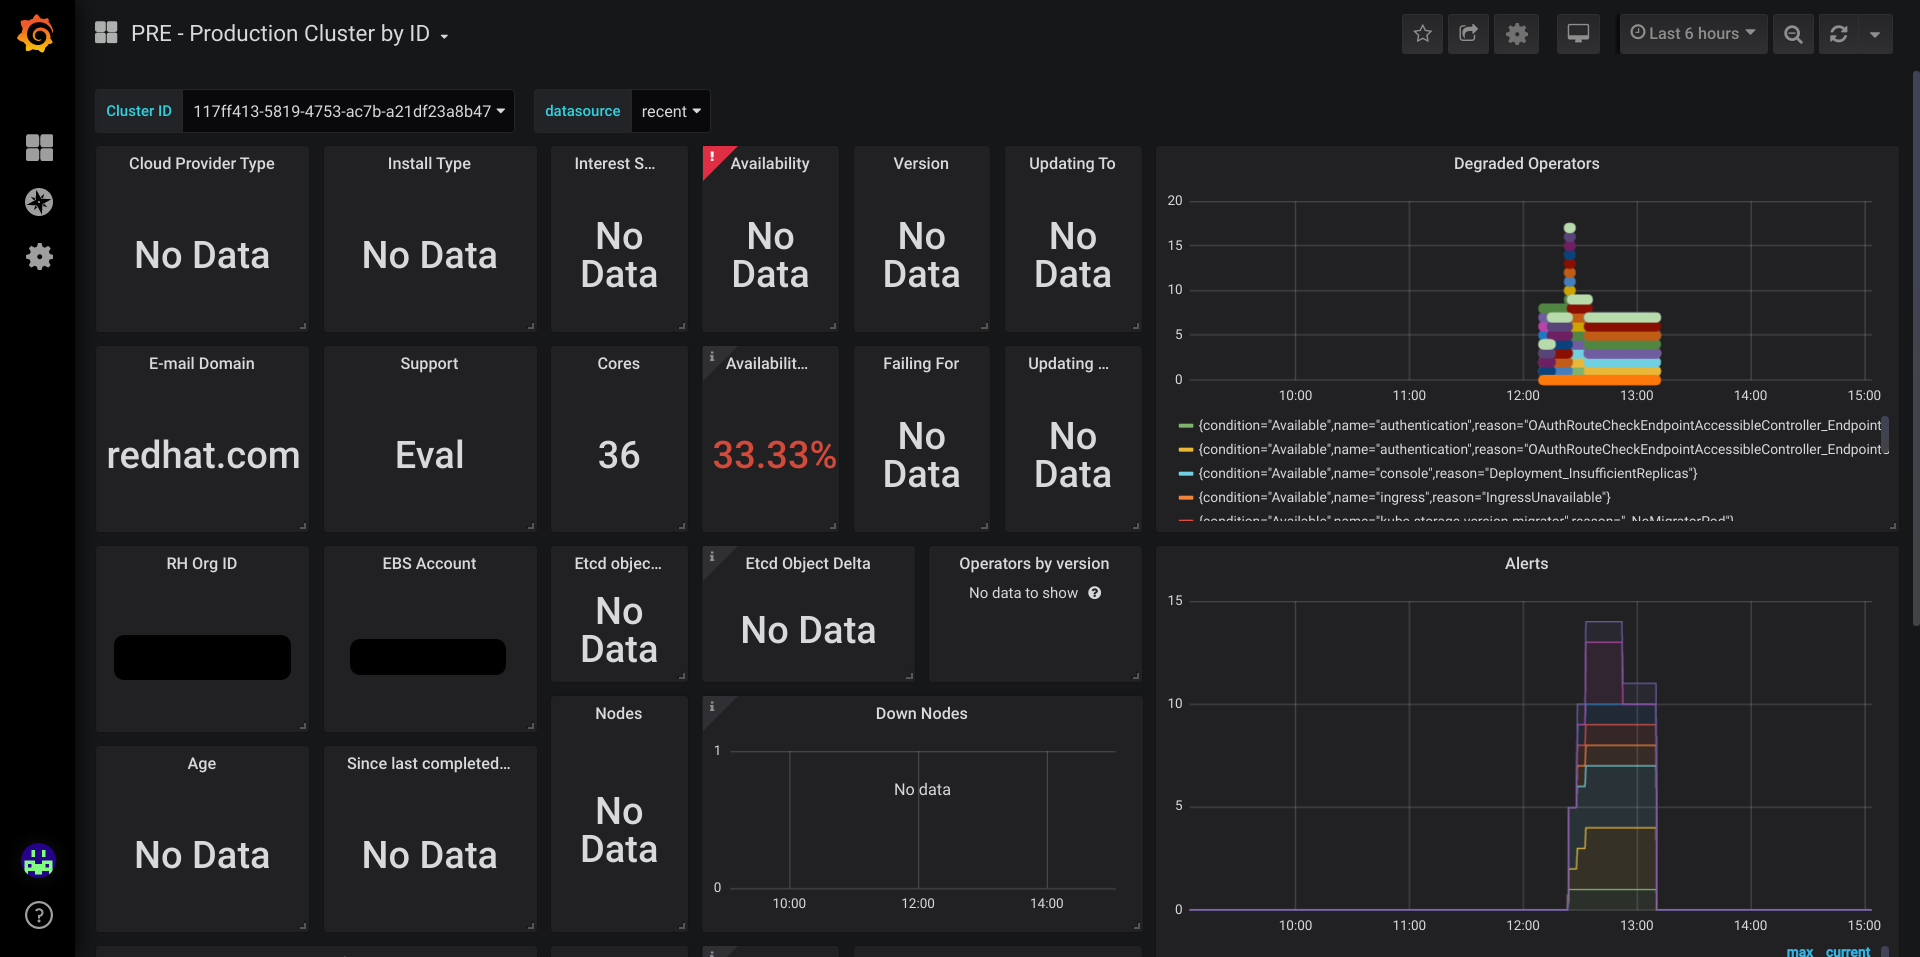

In [13]:
# delta etcd_objects

max_df = prom_query_to_df_cached(
    pc,
    f'max by (_id) ( delta(instance:etcd_object_counts:sum{{_id=~"{cids_filter}"}}[6h]) )',
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
).rename(columns={"value": "max"})
min_df = prom_query_to_df_cached(
    pc,
    f'min by (_id) ( delta(instance:etcd_object_counts:sum{{_id=~"{cids_filter}"}}[6h]) )',
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
).rename(columns={"value": "min"})
del_etcd_df = pd.concat(
    [min_df, max_df],
    axis=1,
    join="inner",
    ignore_index=False,
)

del_etcd_df["etcd_object_delta"] = del_etcd_df.apply(
    lambda r: r["min"] if abs(r["min"]) > abs(r["max"]) else r["max"], axis=1
)
del_etcd_df = del_etcd_df.drop(columns=["min", "max", "timestamp"])
del_etcd_df.shape

using cache 2dc743492a3caa5226cfa6fef401370b
using cache cfded33e3b900a0188744c6350efd39f


(112, 1)

In [14]:
# time since last completed update
query = f'sort ( topk by (_id) (1, (time() - cluster_version{{type="completed", _id=~"{cids_filter}"}}) < 1560000000) )'
ts_last_update_df = prom_query_to_df_cached(
    pc,
    query,
    metric_type="numeric",
    keepcols=["_id", "value"],
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
)
ts_last_update_df = ts_last_update_df.rename(
    columns={"value": "ts_last_update"}
)
print(ts_last_update_df.shape)

using cache 7c920a85ca8c274c4554c2476117b8b0
(124, 1)


In [15]:
# api req/s
query = f'sum by (_id) (avg_over_time(code:apiserver_request_count:rate:sum{{_id=~"{cids_filter}"}}[1h]))'
api_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
)
api_df = api_df.rename(columns={"value": "api_reqs"})
print(api_df.shape)

using cache 34c4c3af97a950ca720a7c9dbc060d20
(9, 2)


In [16]:
# api client error rate (4xx errors)
# NOTE: this is modified from the original grafana query in 2 ways -
# 1. regex changed from [4-5] to ^4, added extra '\' to make \\ an escape seq
# 2. removed >0 coz we want 0 entries too
query = f'sum by (_id) (avg_over_time(code:apiserver_request_count:rate:sum{{code=~"4..", _id=~"{cids_filter}"}}[1h]))'
client_errs_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
)
client_errs_df = client_errs_df.rename(columns={"value": "max_cli_errr"})
print(client_errs_df.shape)

using cache 12038b5771a66b7f5540dbf52baeec8c
(9, 2)


In [17]:
# api server error rate (5xx errors)
# NOTE: this is modified from the original grafana query in 3 ways
# 1. regex changed from [4-5] to ^5
# 2. added extra '\' to make \\ an escape seq
# 3. removed >0 coz we want 0 entries too
query = f'sum by (_id) (avg_over_time(code:apiserver_request_count:rate:sum{{code=~"5..", _id=~"{cids_filter}"}}[1h]))'
server_errs_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
)
server_errs_df = server_errs_df.rename(columns={"value": "max_serv_errr"})
print(server_errs_df.shape)

using cache b890291d511dab64d85de3fd20bbe3f9
(7, 2)


In [18]:
# cpu cores
query = (
    f'sum by (_id) (cluster:capacity_cpu_cores:sum{{_id=~"{cids_filter}"}})'
)
cpu_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
)
cpu_df = cpu_df.rename(columns={"value": "cores"})
print(cpu_df.shape)

using cache 6c6db804952c3c824117c5aaa7a49dd2
(124, 2)


In [19]:
# cpu utlization overall
query = f'max by (_id) (cluster:cpu_usage_cores:sum{{_id=~"{cids_filter}"}}) \
/ on (_id) max by (_id) (sum by (_id) (cluster:capacity_cpu_cores:sum{{_id=~"{cids_filter}"}}))'
cpu_util_total_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
)
cpu_util_total_df = cpu_util_total_df.rename(
    columns={"value": "cpu_util_total"}
)
print(cpu_util_total_df.shape)

using cache 623260af800f2511e98067ea35a1d6b7
(124, 2)


In [20]:
# cpu utilization workload
query = f'max by (_id) (workload:cpu_usage_cores:sum{{_id=~"{cids_filter}"}}) \
/ on (_id) max by (_id) (sum by (_id) (cluster:capacity_cpu_cores:sum{{_id=~"{cids_filter}"}}))'
cpu_util_wl_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
)
cpu_util_wl_df = cpu_util_wl_df.rename(columns={"value": "cpu_util_wl"})
print(cpu_util_wl_df.shape)

using cache 6323c338da8c0aed57820398a9dc1c7f
(86, 2)


In [21]:
# cpu utilization openshift
query = f'max by (_id) (openshift:cpu_usage_cores:sum{{_id=~"{cids_filter}"}}) \
/ on (_id) max by (_id) (sum by (_id) (cluster:capacity_cpu_cores:sum{{_id=~"{cids_filter}"}}))'
cpu_util_ocp_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
)
cpu_util_ocp_df = cpu_util_ocp_df.rename(columns={"value": "cpu_util_ocp"})
print(cpu_util_ocp_df.shape)

using cache 9e0dd85f34777c86f8061be850cb3cd7
(86, 2)


In [22]:
# memory
query = (
    f'sum by (_id) (cluster:capacity_memory_bytes:sum{{_id=~"{cids_filter}"}})'
)
mem_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
)
mem_df = mem_df.rename(columns={"value": "memory"})
print(mem_df.shape)

using cache fcb0afaf911da823825bad7d441b708b
(124, 2)


In [23]:
# masters
query = f'sum by(_id) (cluster:node_instance_type_count:sum\
{{label_node_role_kubernetes_io="master", _id=~"{cids_filter}"}})'
masters_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
)
masters_df = masters_df.rename(columns={"value": "masters"})
print(masters_df.shape)

using cache f417f332d760aca60f0cbc1d93427b43
(124, 2)


In [24]:
# nodes
query = f'sum by (_id) (cluster:node_instance_type_count:sum{{_id=~"{cids_filter}"}})'
nodes_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    at_timestamp=query_eval_timestamp,
)
nodes_df = nodes_df.rename(columns={"value": "nodes"})
print(nodes_df.shape)

using cache 6f7a712464e2241011b19ca3f6a45b14
(124, 2)


### etcd Characterisitcs
In previous experiments, it was found that etcd object count was is quite an important factor in finding anomalies. So in this subsection, we fetch more descriptive features about etcd objects across instances, for a deployment.

In [25]:
# mean, std in etcd objects across instances

# base query
etcd_instance_query = f'max without (replica) (instance:etcd_object_counts:sum{{_id=~"{cids_filter}"}})'

# queries that get instance-wide stats on etcd object count
inst_stats_queries = dict()
inst_stats_queries["mean"] = f"avg by (_id) ({etcd_instance_query})"
inst_stats_queries["stddev"] = f"stddev by (_id) ({etcd_instance_query})"

all_dfs = []
for stat, query in inst_stats_queries.items():
    all_dfs.append(
        prom_query_to_df_cached(
            pc,
            promql=query,
            metric_type="numeric",
            at_timestamp=query_eval_timestamp,
            cache_dir="../../data/raw",
        )
    )
    all_dfs[-1] = all_dfs[-1].rename(
        columns={"value": f"{stat}_instance_etcd_objs_sum"}
    )

# join all stats into one df, ensure there are no nans
etcd_inst_stats_df = pd.concat(all_dfs, axis=1)
assert ~etcd_inst_stats_df.isna().any().any()
print(etcd_inst_stats_df.shape)

using cache cde51ee6c09e26e6357bdbfa890a0e25
using cache a636da40d492e233c6fb7519fd829a3c
(118, 4)


### Combine All Features
Now that we have collected all the individual features, we will combine them to create one dataset.

In [26]:
# combine all features into 1 df
deployment_df = pd.concat(
    [
        payload_df,
        usg_cores_df,
        usg_mem_df,
        ocp_usg_cores_df,
        ocp_usg_mem_df,
        wl_usg_cores_df,
        wl_usg_mem_df,
        etcd_inst_stats_df,
        del_etcd_df,
        ts_last_update_df,
        api_df,
        client_errs_df,
        server_errs_df,
        cpu_df,
        cpu_util_total_df,
        cpu_util_wl_df,
        cpu_util_ocp_df,
        mem_df,
        masters_df,
        nodes_df,
    ],
    axis=1,
    join="outer",
    ignore_index=False,
)

# drop extra timestamp columns return by prometheus_connect
deployment_df = deployment_df.drop("timestamp", axis=1)
print(deployment_df.shape)
deployment_df.head()

(134, 22)


,cluster_version_payload_type_applied,cluster_version_payload_type_pending,cluster:cpu_usage_cores:sum,cluster:memory_usage_bytes:sum,openshift:cpu_usage_cores:sum,openshift:memory_usage_bytes:sum,workload:cpu_usage_cores:sum,workload:memory_usage_bytes:sum,mean_instance_etcd_objs_sum,stddev_instance_etcd_objs_sum,...,api_reqs,max_cli_errr,max_serv_errr,cores,cpu_util_total,cpu_util_wl,cpu_util_ocp,memory,masters,nodes
00c09347-53be-4c01-bfcb-65358793f8fd,432.0,3.0,NaN,1.270488e+10,NaN,NaN,NaN,NaN,2783.000000,2290.964426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03505e84-2bb2-4333-9cbd-a80deb095766,606.0,0.0,4.209416,2.532191e+10,4.209385,2.531161e+10,0.000031,10301440.0,4684.666667,4093.795984,...,NaN,NaN,NaN,18.0,0.233856,0.000002,0.233855,7.399490e+10,3.0,6.0
03f35085-ef7c-4cfd-97cd-a5ad88b605e1,606.0,0.0,3.531810,1.881343e+10,NaN,NaN,NaN,NaN,3713.000000,3889.801280,...,NaN,NaN,NaN,18.0,0.196212,NaN,NaN,7.333659e+10,3.0,6.0
045d07b7-ec0b-4deb-970d-556a1169eacd,606.0,0.0,4.561873,2.514884e+10,NaN,NaN,NaN,NaN,4475.333333,3938.365256,...,NaN,NaN,NaN,36.0,0.126719,NaN,NaN,1.515061e+11,3.0,6.0
0a5aa8e0-4961-4974-8e49-0a78c0656b4f,606.0,0.0,3.737794,2.085185e+10,3.724256,2.079255e+10,0.013538,59297792.0,4549.500000,4012.679975,...,NaN,NaN,NaN,18.0,0.207655,0.000752,0.206903,7.399491e+10,3.0,6.0


## Handle Missing Data

In the notebook with production cluster data, there are not as many missing nans as ci/cd cluster data. Therefore we could easily drop nans. Here, however we have a very small amount of data. If we just drop all rows that have any nans at all then we'll lose a lot of data.

We explore some nan handling strategies in the notebook [here](https://github.com/chauhankaranraj/ocp4-anomaly-detection/blob/wip-ad-demo-public/notebooks/experimental/cicd_anomaly_detection_cleandata.ipynb). We'll use the strategies that proved to be the most helpful (specifically, resulted in having ~46% more data available for training while still being able to retain some info from features).

### Granular details missing

In this case, we have the overall cpu usage, memory usage, etc. but not finer details like openshift cpu usage vs workload cpu usage. We will fill the missing values in these columns with the median expected behavior. For e.g. if the median openshift-workload split is 20:80 and the overall cpu usage is 4 cores, then we'll fill in 0.8 for openshift cpu usage and 3.2 for workload cpu usage.

In [27]:
# either one of the cpu usage granular info is nan and overall is non nan
indexer = (
    (
        deployment_df["workload:cpu_usage_cores:sum"].isna()
        | deployment_df["openshift:cpu_usage_cores:sum"].isna()
    )
    & ~deployment_df["cluster:cpu_usage_cores:sum"].isna()
    & ~deployment_df["cores"].isna()
)

# fill with average split
median_wl_split = (
    deployment_df["workload:cpu_usage_cores:sum"]
    / deployment_df["cluster:cpu_usage_cores:sum"]
).median()
median_ocp_split = (
    deployment_df["openshift:cpu_usage_cores:sum"]
    / deployment_df["cluster:cpu_usage_cores:sum"]
).median()

deployment_df.loc[indexer, "workload:cpu_usage_cores:sum"] = (
    deployment_df.loc[indexer, "cluster:cpu_usage_cores:sum"] * median_wl_split
)
deployment_df.loc[indexer, "openshift:cpu_usage_cores:sum"] = (
    deployment_df.loc[indexer, "cluster:cpu_usage_cores:sum"]
    * median_ocp_split
)

In [28]:
# either one of the cpu util granular info is nan and overall is non nan
indexer = (
    (
        deployment_df["cpu_util_wl"].isna()
        | deployment_df["cpu_util_ocp"].isna()
    )
    & ~deployment_df["cpu_util_total"].isna()
    & ~deployment_df["cores"].isna()
)

# fill with average split
median_wl_split = (
    deployment_df["cpu_util_wl"] / deployment_df["cpu_util_total"]
).median()
median_ocp_split = (
    deployment_df["cpu_util_ocp"] / deployment_df["cpu_util_total"]
).median()

median_ocp_split, median_wl_split
deployment_df.loc[indexer, "cpu_util_wl"] = (
    deployment_df.loc[indexer, "cpu_util_total"] * median_wl_split
)
deployment_df.loc[indexer, "cpu_util_ocp"] = (
    deployment_df.loc[indexer, "cpu_util_total"] * median_ocp_split
)

In [29]:
# either one of the mem usage granular info is nan and overall is non nan
indexer = (
    (
        deployment_df["workload:memory_usage_bytes:sum"].isna()
        | deployment_df["openshift:memory_usage_bytes:sum"].isna()
    )
    & ~deployment_df["cluster:memory_usage_bytes:sum"].isna()
    & ~deployment_df["memory"].isna()
)

# fill with average split
median_wl_split = (
    deployment_df["workload:memory_usage_bytes:sum"]
    / deployment_df["cluster:memory_usage_bytes:sum"]
).median()
median_ocp_split = (
    deployment_df["openshift:memory_usage_bytes:sum"]
    / deployment_df["cluster:memory_usage_bytes:sum"]
).median()

deployment_df.loc[indexer, "workload:memory_usage_bytes:sum"] = (
    deployment_df.loc[indexer, "cluster:memory_usage_bytes:sum"]
    * median_wl_split
)
deployment_df.loc[indexer, "openshift:memory_usage_bytes:sum"] = (
    deployment_df.loc[indexer, "cluster:memory_usage_bytes:sum"]
    * median_ocp_split
)

### etcd details missing

Some etcd attributes we use as featuers are based on behavior of etcd objects in the last 6 hours. However, not all ci/cd clusters live that long. So we try to interpolate the etcd features based on the data we have from other clusters.

In [30]:
# create interpolators
mean_inst_etcd_interpolator = interp2d(
    x=deployment_df.loc[
        ~deployment_df["mean_instance_etcd_objs_sum"].isna()
        & ~deployment_df["masters"].isna(),
        "cluster:memory_usage_bytes:sum",
    ],
    y=deployment_df.loc[
        ~deployment_df["mean_instance_etcd_objs_sum"].isna()
        & ~deployment_df["masters"].isna(),
        "cluster:cpu_usage_cores:sum",
    ],
    z=deployment_df.loc[
        ~deployment_df["mean_instance_etcd_objs_sum"].isna()
        & ~deployment_df["masters"].isna(),
        "mean_instance_etcd_objs_sum",
    ],
)

stddev_inst_etcd_interpolator = interp2d(
    x=deployment_df.loc[
        ~deployment_df["stddev_instance_etcd_objs_sum"].isna()
        & ~deployment_df["masters"].isna(),
        "cluster:memory_usage_bytes:sum",
    ],
    y=deployment_df.loc[
        ~deployment_df["stddev_instance_etcd_objs_sum"].isna()
        & ~deployment_df["masters"].isna(),
        "cluster:cpu_usage_cores:sum",
    ],
    z=deployment_df.loc[
        ~deployment_df["stddev_instance_etcd_objs_sum"].isna()
        & ~deployment_df["masters"].isna(),
        "mean_instance_etcd_objs_sum",
    ],
)

No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=12,14 m=116 fp=19248101.291023 s=0.000000


In [31]:
# fill in missing values using above interpolators
def interpolate_etcd_stats(row):
    global mean_inst_etcd_interpolator, stddev_inst_etcd_interpolator
    if not np.isnan(row["masters"]):
        if np.isnan(row["mean_instance_etcd_objs_sum"]):
            row["mean_instance_etcd_objs_sum"] = mean_inst_etcd_interpolator(
                x=row["cluster:memory_usage_bytes:sum"],
                y=row["cluster:cpu_usage_cores:sum"],
            )
        if np.isnan(row["stddev_instance_etcd_objs_sum"]):
            row[
                "stddev_instance_etcd_objs_sum"
            ] = stddev_inst_etcd_interpolator(
                x=row["cluster:memory_usage_bytes:sum"],
                y=row["cluster:cpu_usage_cores:sum"],
            )


_ = deployment_df.apply(interpolate_etcd_stats, axis=1)

In [32]:
# create interpolator
delta_etcd_interpolator = interp2d(
    x=deployment_df.loc[
        ~deployment_df["etcd_object_delta"].isna()
        & ~deployment_df["masters"].isna(),
        "cluster_version_payload_type_pending",
    ],
    y=deployment_df.loc[
        ~deployment_df["etcd_object_delta"].isna()
        & ~deployment_df["masters"].isna(),
        "memory",
    ],
    z=deployment_df.loc[
        ~deployment_df["etcd_object_delta"].isna()
        & ~deployment_df["masters"].isna(),
        "etcd_object_delta",
    ],
)

No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=14,12 m=112 fp=354564693.591586 s=0.000000


In [33]:
# fill in missing values using above interpolators
def interpolate_delta_etcd(row):
    global delta_etcd_interpolator
    if not np.isnan(row["masters"]):
        if np.isnan(row["etcd_object_delta"]):
            row["etcd_object_delta"] = delta_etcd_interpolator(
                x=row["cluster_version_payload_type_pending"],
                y=row["memory"],
            )


_ = deployment_df.apply(interpolate_delta_etcd, axis=1)

### API req/s missing

If there are no HTTP status codes being generated, then we can safely use 0 instead of nans to represent that.

In [34]:
# if it is reporting master and worker nodes, it must be an "existing" cluster
indexer = deployment_df["api_reqs"].isna() & ~deployment_df["masters"].isna()

deployment_df.loc[indexer, "api_reqs"] = 0
deployment_df.loc[indexer, "max_cli_errr"] = 0
deployment_df.loc[indexer, "max_serv_errr"] = 0

In [35]:
# drop rows that still have nans
deployment_df = deployment_df.dropna()

In [36]:
# results after nan handling
print("with nan handling:", deployment_df.shape)

deployment_df2 = pd.concat(
    [
        payload_df,
        usg_cores_df,
        ocp_usg_cores_df,
        wl_usg_cores_df,
        usg_mem_df,
        ocp_usg_mem_df,
        wl_usg_mem_df,
        etcd_inst_stats_df,
        del_etcd_df,
        ts_last_update_df,
        #         api_df,
        #         client_errs_df,
        #         server_errs_df,
        cpu_df,
        cpu_util_total_df,
        cpu_util_wl_df,
        cpu_util_ocp_df,
        mem_df,
        masters_df,
        nodes_df,
    ],
    axis=1,
    join="inner",
    ignore_index=False,
)

# drop extra timestamp columns return by prometheus_connect
deployment_df2 = deployment_df2.drop("timestamp", axis=1)

print("without nan handling:", deployment_df2.shape)
print(
    f"percent of rows gained = {100 * (deployment_df.shape[0]-deployment_df2.shape[0]) / deployment_df2.shape[0]} %"
)

with nan handling: (115, 22)
without nan handling: (79, 19)
percent of rows gained = 45.56962025316456 %


## Collect Metrics used as Metadata

The data collected in this section are not necessarily features that will be input to the models. However, this data will be used for other purposes like validation of models, filtering deployments based on version.

In [37]:
# Version Info
# get the most recent "current" version, as of timestamp
versions_df = prom_query_to_df_cached(
    pc,
    f'max by (_id, version) (cluster_version{{type="current", _id=~"{cids_filter}"}})',
    metric_type="numeric",
    keepcols=["_id", "version", "value"],
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
).reset_index()

# drop any duplicates, keeping the most recent value
versions_df = (
    versions_df.sort_values("value")
    .drop_duplicates(subset="_id", keep="last")
    .set_index("_id")
)

# extract "major.minor.patch" version from long version strings
versions_df["version"] = versions_df["version"].apply(
    lambda x: x.split("-")[0]
)

using cache a76f3e99c3b5a0638fb6971def857eff


In [38]:
# Alerts Info
# NOTE: alertstate is always firing so value is always 1.
query = f'alerts{{alertname!="Watchdog", _id=~"{cids_filter}"}}'
alerts_df = prom_query_to_df_cached(
    pc,
    query,
    metric_type="boolean",
    keepcols=["_id", "value", "alertname", "severity"],
    at_timestamp=query_eval_timestamp,
    cache_dir="../../data/raw",
)

using cache ec8cd4c4f1d9b290ed069fb33417067d


In [39]:
# Failing Info
# failing query, as defined on the grafana dashboard, as of query_eval_timestamp
query = f'max by (_id,version) ((time() - cluster_version{{type="failure", _id=~"{cids_filter}"}})) > 3 * 60 * 60'
failing_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="timestamp",
    at_timestamp=query_eval_timestamp,
)

using cache 111f5f831ca1e47a4dca2d8fb4e7cfa6


In [40]:
# Email Domain Info
query = f'topk by (_id) (1, subscription_labels{{_id=~"{cids_filter}"}})'
email_df = prom_query_to_df_cached(
    pc,
    query,
    cache_dir="../../data/raw",
    metric_type="numeric",
    keepcols=["_id", "email_domain"],
    at_timestamp=query_eval_timestamp,
)

using cache 02d3a629dffeb5352b2129d43c32ebec


## Create Training Dataset

In this section, you can filter the deployments data by version and customer email domain. This is useful in narrowing down the scope in which "normal" and "anomalous" are defined. The filtered dataframe will then be preprocessed and used for training anomaly detection models.

In [41]:
# how many deployments of each version
depls_per_version = versions_df["version"].value_counts()
depls_per_version["ALL"] = depls_per_version.sum()

# widget to select version, showing in descending order of # depls
version_widget_options = [
    f"{val} ({ct} depls)"
    for val, ct in depls_per_version.sort_values(ascending=False).iteritems()
]
version_widget = widgets.Select(
    options=version_widget_options,
    value=version_widget_options[0],
    description="Version",
)

display(version_widget)

Select(description='Version', options=('ALL (134 depls)', '0.0.1 (101 depls)', '4.5.0 (12 depls)', '4.4.0 (6 d…

In [42]:
# filter data by verison,email
VERSION = version_widget.value.split()[0]
print(f"version = {VERSION}")

X_df = deployment_df.copy(deep=True)

# keep only deployments of selected version
if VERSION.lower() != "all":
    X_df = X_df[
        X_df.index.isin(versions_df[versions_df["version"] == VERSION].index)
    ]

# drop nan rows
X_df = X_df.dropna()

print(X_df.shape)
X_df.head()

version = ALL
(115, 22)


,cluster_version_payload_type_applied,cluster_version_payload_type_pending,cluster:cpu_usage_cores:sum,cluster:memory_usage_bytes:sum,openshift:cpu_usage_cores:sum,openshift:memory_usage_bytes:sum,workload:cpu_usage_cores:sum,workload:memory_usage_bytes:sum,mean_instance_etcd_objs_sum,stddev_instance_etcd_objs_sum,...,api_reqs,max_cli_errr,max_serv_errr,cores,cpu_util_total,cpu_util_wl,cpu_util_ocp,memory,masters,nodes
03505e84-2bb2-4333-9cbd-a80deb095766,606.0,0.0,4.209416,2.532191e+10,4.209385,2.531161e+10,0.000031,1.030144e+07,4684.666667,4093.795984,...,0.0,0.0,0.0,18.0,0.233856,0.000002,0.233855,7.399490e+10,3.0,6.0
03f35085-ef7c-4cfd-97cd-a5ad88b605e1,606.0,0.0,3.531810,1.881343e+10,3.528892,1.873615e+10,0.002918,7.727951e+07,3713.000000,3889.801280,...,0.0,0.0,0.0,18.0,0.196212,0.000162,0.196050,7.333659e+10,3.0,6.0
045d07b7-ec0b-4deb-970d-556a1169eacd,606.0,0.0,4.561873,2.514884e+10,4.558104,2.504553e+10,0.003769,1.033033e+08,4475.333333,3938.365256,...,0.0,0.0,0.0,36.0,0.126719,0.000105,0.126614,1.515061e+11,3.0,6.0
0a5aa8e0-4961-4974-8e49-0a78c0656b4f,606.0,0.0,3.737794,2.085185e+10,3.724256,2.079255e+10,0.013538,5.929779e+07,4549.500000,4012.679975,...,0.0,0.0,0.0,18.0,0.207655,0.000752,0.206903,7.399491e+10,3.0,6.0
0ab72a2a-d6a0-4ea1-a2ba-57d438d4447a,584.0,0.0,6.656550,2.393933e+10,6.509089,2.314962e+10,0.147461,7.897129e+08,4418.000000,3836.175483,...,0.0,0.0,0.0,18.0,0.369808,0.008192,0.361616,7.549854e+10,3.0,6.0


## Preprocess Data

In this section, we will preprocess the raw data i.e. "normalize" the values in each column.

In [43]:
# make data more gaussian looking
ptrans = PowerTransformer()
ptrans.fit(X_df)
X_df_trans = ptrans.transform(X_df)

# see what the scaled data looks like
pd.DataFrame(X_df_trans, index=X_df.index, columns=X_df.columns).head()

divide by zero encountered in log


,cluster_version_payload_type_applied,cluster_version_payload_type_pending,cluster:cpu_usage_cores:sum,cluster:memory_usage_bytes:sum,openshift:cpu_usage_cores:sum,openshift:memory_usage_bytes:sum,workload:cpu_usage_cores:sum,workload:memory_usage_bytes:sum,mean_instance_etcd_objs_sum,stddev_instance_etcd_objs_sum,...,api_reqs,max_cli_errr,max_serv_errr,cores,cpu_util_total,cpu_util_wl,cpu_util_ocp,memory,masters,nodes
03505e84-2bb2-4333-9cbd-a80deb095766,0.689429,-0.616276,-0.322911,0.0,-0.314678,0.0,-0.983895,-1.336701,0.258845,0.207505,...,-0.254588,-0.254588,-0.119011,-1.182456,0.166830,-0.924196,0.175018,0.0,0.0,-0.041439
03f35085-ef7c-4cfd-97cd-a5ad88b605e1,0.689429,-0.616276,-0.856030,0.0,-0.849786,0.0,-0.555984,-0.353647,-0.460899,0.066840,...,-0.254588,-0.254588,-0.119011,-1.182456,-0.295972,-0.468449,-0.290638,0.0,0.0,-0.041439
045d07b7-ec0b-4deb-970d-556a1169eacd,0.689429,-0.616276,-0.102288,0.0,-0.096533,0.0,-0.440604,-0.187375,0.112736,0.100680,...,-0.254588,-0.254588,-0.119011,1.991608,-1.523338,-0.624182,-1.521229,0.0,0.0,-0.041439
0a5aa8e0-4961-4974-8e49-0a78c0656b4f,0.689429,-0.616276,-0.675950,0.0,-0.678528,0.0,0.599392,-0.499499,0.165006,0.152033,...,-0.254588,-0.254588,-0.119011,-1.182456,-0.143149,0.744532,-0.145028,0.0,0.0,-0.041439
0ab72a2a-d6a0-4ea1-a2ba-57d438d4447a,0.379011,-0.616276,0.753017,0.0,0.716646,0.0,2.420122,1.192134,0.071938,0.029209,...,-0.254588,-0.254588,-0.119011,-1.182456,1.166572,2.496414,1.134527,0.0,0.0,-0.041439


## Anomaly Detection
Now our dataset is ready to be used for training anomaly detection models. In this section, we will train two models - Isolation Forest and Local Outlier Factor.

### Local Outlier Factor

In [44]:
# train vanilla LOF
lof = LocalOutlierFactor(
    contamination=0.05,
)

# fit lof
is_inlier = lof.fit_predict(X_df_trans)
scores = lof.negative_outlier_factor_

# find depl ids of inliers and outliers
outlier_ids = X_df.iloc[is_inlier != 1].index
inlier_ids = X_df.index.difference(outlier_ids)

# put predictions from LOF in a nice df
results_lof = pd.DataFrame(
    list(zip(is_inlier, scores)),
    index=X_df.index,
    columns=["prediction_lof", "score_lof"],
)

# sort by score, then assign percentiles
results_lof = results_lof.sort_values(by="score_lof")
results_lof["score_percentile_lof"] = results_lof["score_lof"].apply(
    lambda row: 100 - stats.percentileofscore(results_lof["score_lof"], row)
)

print("\n=============== STATS ===============\n")
print("Number of Outliers = {:4d}".format(len(outlier_ids)))
print("Percent marked Outliers = {:.5f}".format(len(outlier_ids) / len(X_df)))
print("\nTop 5 outlier deployment ids:")
# display top 5. if <5 anomalies, print "-"
for i, (cid, cdata) in enumerate(results_lof.iloc[:5].iterrows()):
    if cdata["prediction_lof"] == -1:
        print("{:2d}) {}".format(i + 1, cid))
    else:
        print("{:2d}) {}".format(i + 1, "-"))

# evaluate performance
print("\n=============== BY ALERTS ===============\n")
validate_by_alertsdf(inlier_ids, outlier_ids, alerts_df)
print("\n=============== BY FAILING ===============\n")
validate_by_failingdf(inlier_ids, outlier_ids, failing_df)


=============== STATS ===============

Number of Outliers =    6
Percent marked Outliers = 0.05217

Top 5 outlier deployment ids:
 1) 377416d7-986d-4c01-86d9-7e45477a9ef0
 2) 6adb62c2-16fa-492f-86aa-8fbd663e2070
 3) 8bebb938-90bd-462b-a752-4aaee769d2ac
 4) a2db1b3a-0c7e-41a6-8c42-d08a463e89ab
 5) c326e07a-f6ae-4ac5-ae74-9e6e315a0b94

=============== BY ALERTS ===============

0.89908 % of total inliers had alerts firing
1.00000 % of total outliers had alerts firing

Mean num alerts in  inliers = 2.13761
Mean num alerts in outliers = 1.83333
Diff = -0.30428

Median num alerts in  inliers = 1.00000
Median num alerts in outliers = 1.00000
Diff = 0.00000

                 num_depls      mean       std min 25% 50%   75% max
severity label                                                      
warning  inlier        109   1.59633   1.73269   0   1   1     2  10
         outlier         6   1.33333  0.816497   1   1   1     1   3
critical inlier        109  0.541284   1.15896   0   0   0     

### Isolation Forest

In [45]:
# train vanilla iForest
isof = IsolationForest(
    contamination=0.05,
    random_state=42,
)

# fit iforest
is_inlier = isof.fit_predict(X_df_trans)
scores = isof.decision_function(X_df_trans)

# find depl ids of inliers and outliers
outlier_ids = X_df.iloc[is_inlier != 1].index
inlier_ids = X_df.index.difference(outlier_ids)

# put predictions from iForest in a nice df
results_if = pd.DataFrame(
    list(zip(is_inlier, scores)),
    index=X_df.index,
    columns=["prediction_if", "score_if"],
)

# sort by score, then assign percentiles
results_if = results_if.sort_values(by="score_if")
results_if["score_percentile_if"] = results_if["score_if"].apply(
    lambda row: 100 - stats.percentileofscore(results_if["score_if"], row)
)

print("\n=============== STATS ===============\n")
print("Number of Outliers = {:4d}".format(len(outlier_ids)))
print("Percent marked Outliers = {:.5f}".format(len(outlier_ids) / len(X_df)))
print("\nTop 5 outlier deployment ids:")
# display top 5. if <5 anomalies, print "-"
for i, (cid, cdata) in enumerate(results_if.iloc[:5].iterrows()):
    if cdata["prediction_if"] == -1:
        print("{:2d}) {}".format(i + 1, cid))
    else:
        print("{:2d}) {}".format(i + 1, "-"))

# evaluate performance
print("\n=============== BY ALERTS ===============\n")
validate_by_alertsdf(inlier_ids, outlier_ids, alerts_df)
print("\n=============== BY FAILING ===============\n")
validate_by_failingdf(inlier_ids, outlier_ids, failing_df)


=============== STATS ===============

Number of Outliers =    6
Percent marked Outliers = 0.05217

Top 5 outlier deployment ids:
 1) 6adb62c2-16fa-492f-86aa-8fbd663e2070
 2) c326e07a-f6ae-4ac5-ae74-9e6e315a0b94
 3) 8bebb938-90bd-462b-a752-4aaee769d2ac
 4) 377416d7-986d-4c01-86d9-7e45477a9ef0
 5) b08e6a7e-9a1f-46fb-b5f2-f8812f5465b0

=============== BY ALERTS ===============

0.89908 % of total inliers had alerts firing
1.00000 % of total outliers had alerts firing

Mean num alerts in  inliers = 2.03670
Mean num alerts in outliers = 3.66667
Diff = 1.62997

Median num alerts in  inliers = 1.00000
Median num alerts in outliers = 3.00000
Diff = 2.00000

                 num_depls      mean       std min   25%  50%   75% max
severity label                                                         
warning  inlier        109   1.51376   1.57888   0     1    1     2  10
         outlier         6   2.83333   3.12517   1     1  1.5  2.75   9
critical inlier        109  0.522936   1.15947   0  

In [46]:
# combine predictions df's from both models
results = pd.merge(
    results_lof, results_if, how="inner", left_index=True, right_index=True
)
common_anomalies_df = results[
    (results["prediction_lof"] == -1) & (results["prediction_if"] == -1)
]

# display the more severe score to the end user
common_anomalies_df = common_anomalies_df.assign(
    anomaly_score=common_anomalies_df[
        ["score_percentile_lof", "score_percentile_if"]
    ].max(axis=1)
)

common_anomalies_df

,prediction_lof,score_lof,score_percentile_lof,prediction_if,score_if,score_percentile_if,anomaly_score
377416d7-986d-4c01-86d9-7e45477a9ef0,-1,-3.580657,99.130435,-1,-0.066212,96.521739,99.130435
6adb62c2-16fa-492f-86aa-8fbd663e2070,-1,-2.982470,98.260870,-1,-0.103920,99.130435,99.130435
8bebb938-90bd-462b-a752-4aaee769d2ac,-1,-2.596842,97.391304,-1,-0.074482,97.391304,97.391304
c326e07a-f6ae-4ac5-ae74-9e6e315a0b94,-1,-2.104894,95.652174,-1,-0.080032,98.260870,98.260870


In [47]:
# validation report based on output from both models
common_outlier_ids = common_anomalies_df.index
common_inlier_ids = X_df.index.difference(common_outlier_ids)

print("\n=============== STATS ===============\n")
print("Number of Outliers = {:4d}".format(len(common_outlier_ids)))
print(
    "Percent marked Outliers = {:.5f}".format(
        len(common_outlier_ids) / len(X_df)
    )
)
print("\nTop 5 outlier deployment ids:")
# display top 5. if <5 anomalies, print "-"
for i in range(5):
    if i < len(common_anomalies_df):
        print("{:2d}) {}".format(i + 1, common_outlier_ids[i]))
    else:
        print("{:2d}) {}".format(i + 1, "-"))

# evaluate performance
print("\n=============== BY ALERTS ===============\n")
validate_by_alertsdf(common_inlier_ids, common_outlier_ids, alerts_df)
print("\n=============== BY FAILING ===============\n")
validate_by_failingdf(common_inlier_ids, common_outlier_ids, failing_df)


=============== STATS ===============

Number of Outliers =    4
Percent marked Outliers = 0.03478

Top 5 outlier deployment ids:
 1) 377416d7-986d-4c01-86d9-7e45477a9ef0
 2) 6adb62c2-16fa-492f-86aa-8fbd663e2070
 3) 8bebb938-90bd-462b-a752-4aaee769d2ac
 4) c326e07a-f6ae-4ac5-ae74-9e6e315a0b94
 5) -

=============== BY ALERTS ===============

0.90090 % of total inliers had alerts firing
1.00000 % of total outliers had alerts firing

Mean num alerts in  inliers = 2.11712
Mean num alerts in outliers = 2.25000
Diff = 0.13288

Median num alerts in  inliers = 1.00000
Median num alerts in outliers = 2.00000
Diff = 1.00000

                 num_depls      mean       std min 25%  50%   75% max
severity label                                                       
warning  inlier        111   1.58559   1.71871   0   1    1     2  10
         outlier         4       1.5         1   1   1    1   1.5   3
critical inlier        111  0.531532   1.15065   0   0    0     0   7
         outlier         

**NOTE** As seen in the above dataframe, we have predictions and scores from two different models. Without SME input, it's not straightforward to determine which model is producing more meaningful results. Therefore, we label a deployment as anomalous only when both models claim it to be so (i.e. there is higher confidence that the deployment really is anomalous).

When it comes to displaying the anomaly scores, if we show scores from both models to the end user, then it might confuse them. So as a workaround we display the score that is more severe of the two.

## Explaining Predictions: Deployment Level Insights

Now that we have trained the models and gotten anomaly predictions, we want to determine why these deployments got laballed anomalous. That is, specifically what characteristics of the deployment made the model think that it is out of the ordinary? This would give SMEs or support engineers clues about what the underlying problem is, and thus help them fix it.

In this section, we take one deployment that was marked anomalous and try to find the reasons why it was marked so.

In [48]:
# test id
test_id = common_anomalies_df.index[3]

In [49]:
# alerts
test_id_alerts = alerts_df[alerts_df.index == test_id]

# what alerts and at what severity
alert_severity = test_id_alerts.loc[
    :, (test_id_alerts != 0).any(axis=0)
].columns
print("ALERT_SEVERITY firing:\n")
for i in alert_severity:
    print(i)
print()

ALERT_SEVERITY firing:

AlertmanagerReceiversNotConfigured_warning
KubeClientErrors_warning
KubePodNotReady_critical
TargetDown_warning



###  Histograms and How to Interpret Them

In the below cell, we plot one histogram for each feature. Each histogram shows what the distribution of values for the given feature looks like (blue bars) and what value did the feature take for the particular deployment id of interest.

For example, in the first histogram we see that for the deployment marked anomalous, the mean and std in number of etcd objects across instances (`mean_instance_etcd_objs_sum`, `stddev_instance_etcd_objs_sum`) was much lesser than others in the fleet. In the next histogram, we see that most values of `api_reqs` lie around 0 but for the given deployment, the value of was around 50 i.e. much higher than usually seen.

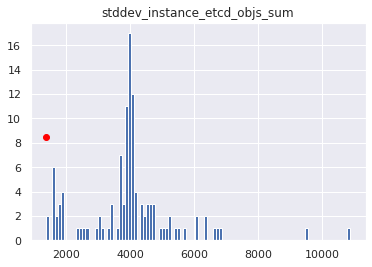

1.76 standard deviations from the mean
cluster value:  1370.8107965725976
dataset mean:  3935.6642369787296
dataset std:  1457.5407370357825


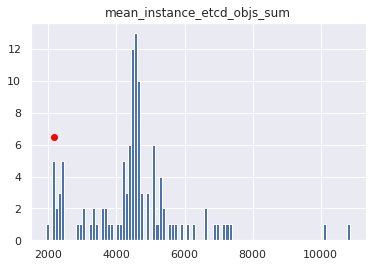

1.596 standard deviations from the mean
cluster value:  2172.6
dataset mean:  4462.811814823825
dataset std:  1434.7384820890018


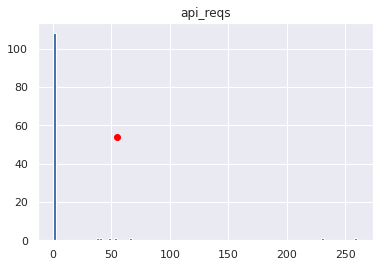

1.429 standard deviations from the mean
cluster value:  54.37160702917659
dataset mean:  6.40285881725827
dataset std:  33.5772175729594


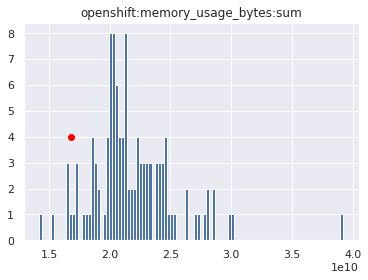

1.425 standard deviations from the mean
cluster value:  16842366755.218279
dataset mean:  21775034111.448868
dataset std:  3461864333.3500857


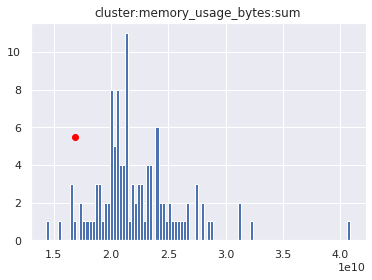

1.419 standard deviations from the mean
cluster value:  16911835136.0
dataset mean:  22187072503.095654
dataset std:  3716356646.414568


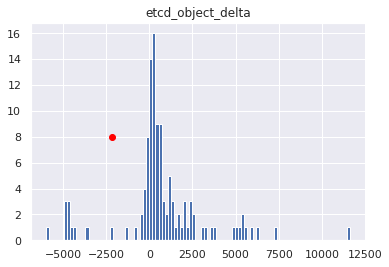

1.126 standard deviations from the mean
cluster value:  -2176.89704845815
dataset mean:  688.1833938786071
dataset std:  2545.006969358059


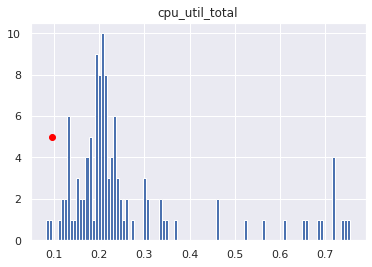

1.03 standard deviations from the mean
cluster value:  0.0955972222222221
dataset mean:  0.26769636983958756
dataset std:  0.16706475449984892


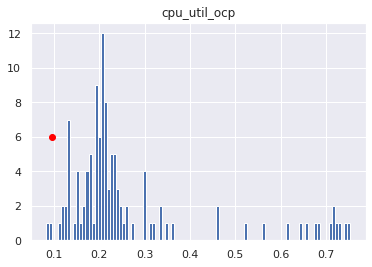

1.03 standard deviations from the mean
cluster value:  0.09551824902755646
dataset mean:  0.26669870882418
dataset std:  0.16622531103737476


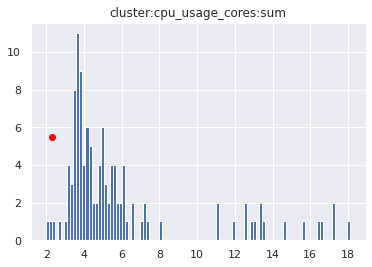

0.98 standard deviations from the mean
cluster value:  2.2943333333333302
dataset mean:  5.93901272640852
dataset std:  3.7189590396888152


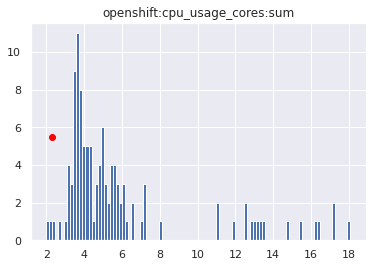

0.979 standard deviations from the mean
cluster value:  2.292437976661355
dataset mean:  5.918039606052049
dataset std:  3.7015891184674707


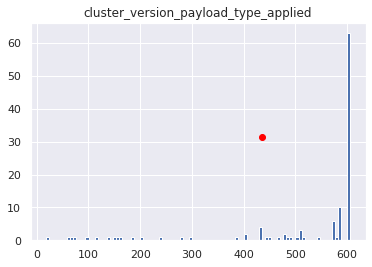

0.534 standard deviations from the mean
cluster value:  435.0
dataset mean:  518.1304347826087
dataset std:  155.8103616658433


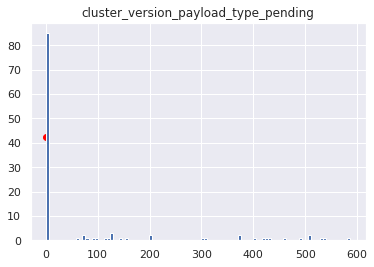

0.481 standard deviations from the mean
cluster value:  0.0
dataset mean:  73.61739130434782
dataset std:  153.11780710545762


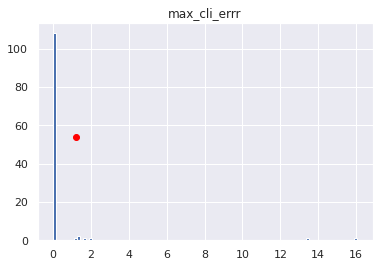

0.448 standard deviations from the mean
cluster value:  1.1992334888953058
dataset mean:  0.3214399663875406
dataset std:  1.9615275142717312


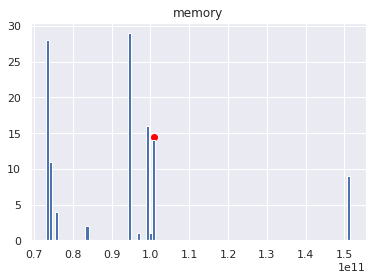

0.404 standard deviations from the mean
cluster value:  100880687104.0
dataset mean:  92538981616.41739
dataset std:  20642437591.44708


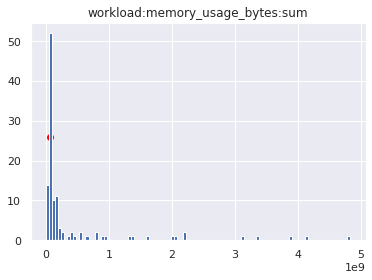

0.393 standard deviations from the mean
cluster value:  69468380.7817207
dataset mean:  412038391.64678645
dataset std:  872338774.6012398


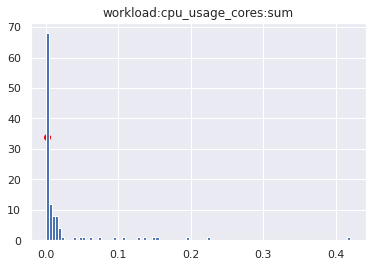

0.351 standard deviations from the mean
cluster value:  0.001895356671975428
dataset mean:  0.020973120356472096
dataset std:  0.054299805225710845


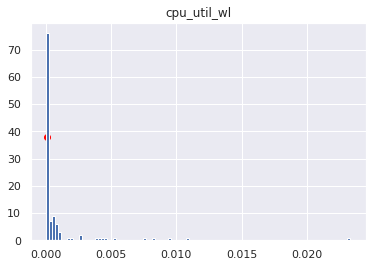

0.329 standard deviations from the mean
cluster value:  7.897319466564284e-05
dataset mean:  0.0009976610154075712
dataset std:  0.00279379155043608


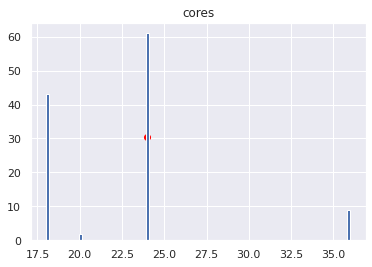

0.284 standard deviations from the mean
cluster value:  24.0
dataset mean:  22.62608695652174
dataset std:  4.829479775778436


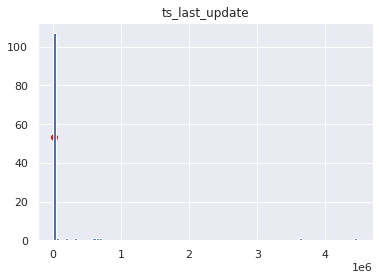

0.158 standard deviations from the mean
cluster value:  11458.0
dataset mean:  97227.40869565218
dataset std:  542542.8004783036


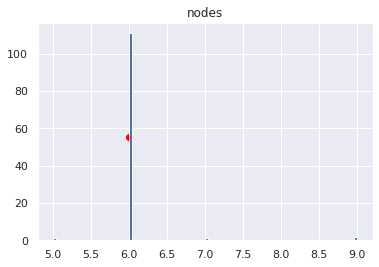

0.126 standard deviations from the mean
cluster value:  6.0
dataset mean:  6.052173913043478
dataset std:  0.41556299289985743


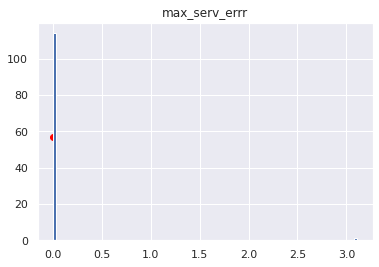

0.093 standard deviations from the mean
cluster value:  0.0
dataset mean:  0.02710000544074791
dataset std:  0.2901478024979602


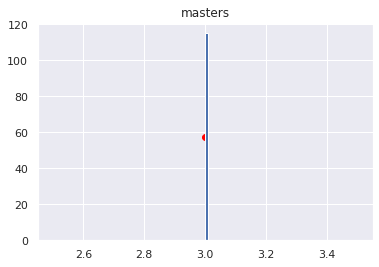

nan standard deviations from the mean
cluster value:  3.0
dataset mean:  3.0
dataset std:  0.0


In [50]:
# graphs
cluster_of_interest = X_df[X_df.index == test_id]
cluster_of_interest

# how many stddev from mean value is each feature, sorted descending
stds_from_means = (
    ((cluster_of_interest - X_df.mean()) / X_df.std())
    .abs()
    .sort_values(by=test_id, axis=1, ascending=False)
)

COLUMNS_TO_PLOT = 50
for column in stds_from_means.columns[:COLUMNS_TO_PLOT]:

    counts = plt.hist(X_df[column], bins=100)
    plt.scatter(cluster_of_interest[column], counts[0].max() / 2, c="red")
    plt.title(column)
    plt.show()

    print(
        round(stds_from_means[column].values[0], 3),
        "standard deviations from the mean",
    )
    print("cluster value: ", cluster_of_interest[column].values[0])
    print("dataset mean: ", X_df[column].mean())
    print("dataset std: ", X_df[column].std())

### SHAP Explanations and How to Interpret Them

In this subsection, we will try to explain model predictions using the [SHAP](https://arxiv.org/abs/1705.07874) method. For a detailed comparison of various explainability methods, and to understand the reasoning for using this method, please see the [anomaly_detection_explainability](anomaly_detection_explainability.ipynb) notebook.

In [51]:
# decision tree surrogate for lof

# use lof predictions as labels
# NOTE: need to change -1/1 to 1/0 so that SHAP average prediction makes sense
# NOTE: need to ensure index is same as X_df otherwise labels are incorrect
lof_surrogate_labels = (
    results_lof["prediction_lof"]
    .replace(to_replace={-1: 1, 1: 0})
    .reindex(X_df.index)
)

# overfit vanilla dt
lof_dt = DecisionTreeClassifier(
    min_samples_split=2,
    class_weight="balanced",
    random_state=42,
)
lof_dt.fit(X_df, lof_surrogate_labels)
print(classification_report(lof_surrogate_labels, lof_dt.predict(X_df)))

print(
    "The model considers the following feature the most important, globally:"
)
pd.Series(
    lof_dt.feature_importances_, index=X_df.columns.tolist()
).sort_values(ascending=False)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00         6

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115

The model considers the following feature the most important, globally:


api_reqs                                0.714286
nodes                                   0.268323
etcd_object_delta                       0.017391
cpu_util_ocp                            0.000000
mean_instance_etcd_objs_sum             0.000000
cluster_version_payload_type_pending    0.000000
cluster:cpu_usage_cores:sum             0.000000
cluster:memory_usage_bytes:sum          0.000000
openshift:cpu_usage_cores:sum           0.000000
openshift:memory_usage_bytes:sum        0.000000
workload:cpu_usage_cores:sum            0.000000
workload:memory_usage_bytes:sum         0.000000
stddev_instance_etcd_objs_sum           0.000000
cpu_util_wl                             0.000000
masters                                 0.000000
ts_last_update                          0.000000
memory                                  0.000000
max_cli_errr                            0.000000
max_serv_errr                           0.000000
cores                                   0.000000
cpu_util_total      

In [52]:
# decision tree surrogate for if

# use if predictions as labels
# NOTE: need to change -1/1 to 1/0 so that SHAP average prediction makes sense
# NOTE: need to ensure index is same as X_df otherwise labels are incorrect
if_surrogate_labels = (
    results_if["prediction_if"]
    .replace(to_replace={-1: 1, 1: 0})
    .reindex(X_df.index)
)

# overfit vanilla dt
if_dt = DecisionTreeClassifier(
    min_samples_split=2,
    class_weight="balanced",
    random_state=42,
)
if_dt.fit(X_df, if_surrogate_labels)
print(classification_report(if_surrogate_labels, if_dt.predict(X_df)))

print(
    "The model considers the following feature the most important, globally:"
)
pd.Series(if_dt.feature_importances_, index=X_df.columns.tolist()).sort_values(
    ascending=False
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00         6

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115

The model considers the following feature the most important, globally:


api_reqs                                0.714663
openshift:memory_usage_bytes:sum        0.285337
nodes                                   0.000000
stddev_instance_etcd_objs_sum           0.000000
cluster_version_payload_type_pending    0.000000
cluster:cpu_usage_cores:sum             0.000000
cluster:memory_usage_bytes:sum          0.000000
openshift:cpu_usage_cores:sum           0.000000
workload:cpu_usage_cores:sum            0.000000
workload:memory_usage_bytes:sum         0.000000
mean_instance_etcd_objs_sum             0.000000
etcd_object_delta                       0.000000
masters                                 0.000000
ts_last_update                          0.000000
max_cli_errr                            0.000000
max_serv_errr                           0.000000
cores                                   0.000000
cpu_util_total                          0.000000
cpu_util_wl                             0.000000
cpu_util_ocp                            0.000000
memory              

In [53]:
# calculate shapley values for lof model
dt_explainer = shap.TreeExplainer(lof_dt, data=X_df, model_output="raw")
np.random.seed(42)
dt_shap_values = dt_explainer.shap_values(X_df)

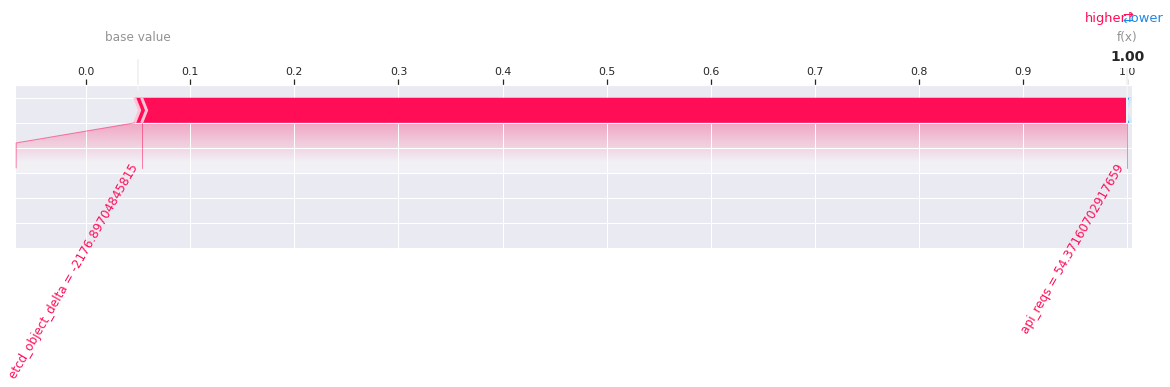

In [54]:
# visualize the prediction's explanation (use matplotlib=True to avoid Javascript)
dt_explainer_ind = 1
shap.force_plot(
    base_value=dt_explainer.expected_value[dt_explainer_ind],
    shap_values=dt_shap_values[dt_explainer_ind][
        X_df.index.get_loc(test_id), :
    ],
    features=X_df.iloc[X_df.index.get_loc(test_id), :],
    feature_names=X_df.columns,
    matplotlib=True,
    text_rotation=60,
)

**How to read this graph:**

In the above graph, the red values depict which features contributed towards model classifying the deployment as "Anomalous", and the blue values depict which features contributed towards classifying it as "Normal". The wider the "tape" (i.e. higher the magnitude of SHAP value), the more impactful the corresponding feature was. Positive values indicate that the feature tipped the decision towards "Anomalous", and negative values indicate it tipped it towards "Normal".

In context of LoF model, for this deployment, features such as number of nodes (`nodes`) had small and negative Shapley values. This implies that these weren't that crucial in deciding "Anomalous vs Normal", but still pushed the decision towards "Normal" by a slight amount.

However, the API request rate (`api_req`) and change in etcd objects in the last 6 hours (`etcd_object_delta`) had high and positive Shapley values i.e. they significantly pushed the decision towards "anomalous".

Most other features had 0 Shapley values, meaning they did not have a huge impact on the model's decision.

In [55]:
# calculate shapley values for isolation forest model
dt_explainer = shap.TreeExplainer(if_dt, data=X_df, model_output="raw")
np.random.seed(42)
dt_shap_values = dt_explainer.shap_values(X_df)

divide by zero encountered in double_scalars


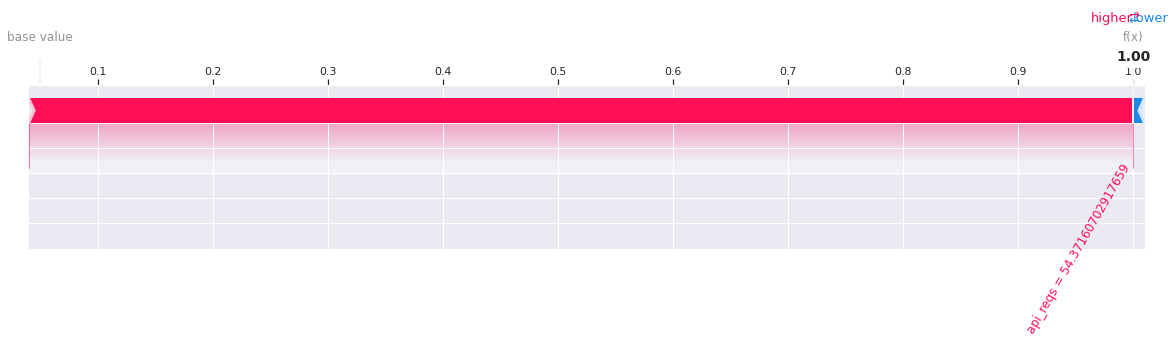

In [56]:
# visualize the prediction's explanation (use matplotlib=True to avoid Javascript)
dt_explainer_ind = 1
shap.force_plot(
    base_value=dt_explainer.expected_value[dt_explainer_ind],
    shap_values=dt_shap_values[dt_explainer_ind][
        X_df.index.get_loc(test_id), :
    ],
    features=X_df.iloc[X_df.index.get_loc(test_id), :],
    feature_names=X_df.columns,
    matplotlib=True,
    text_rotation=60,
)

**How to read this graph:**

This graph is to be read in a similar way as the one above.

In context of Isolation Forest model, for this deployment, features such as memory usage by OpenShift compoenents (`openshift:memory_usage_bytes:sum`) had small and negative Shapley values. This means, they weren't that crucial in deciding "Anomalous vs Normal", but still pushed the decision towards "Normal" by a slight amount.

But, the api request rate (`api_req`) had a high, positive Shapley value. Meaning, it significantly pushed the decision towards "Anomalous".

Most of other features had 0 Shapley values, meaning they did not have a huge impact on the model's decision.

# Conclusion

In this notebook we showed how to collect various metrics that characterize OpenShift deployments, how to put them in a format usable for data science purposes, and finally how to train anomaly detection models. We also showed how histograms and Shapley values can be used to help understand why these models labelled some particular deployments as anomalous and others as normal.

The methods used here were unsupervised - there is no mathematical way of evaluating meaningfulness of results. So as a proxy for true labels, we compared the alerts firing across deployments marked anomalous and normal. As seen above, anomalous deployments tend to have a lot more alerts firing than normal ones. The histograms also show that the metric values for anomalous deployments tend to be "out of the ordinary". Lastly, the SHAP explanations also seem quite reasonable (e.g. high number of etcd objects, high api req/s, etc. seem plausible causes for "anomalousness" in deployments). These results suggest that our models are generating somewhat meaningful results. But to confirm this, we need to get these results to SMEs / support engineers and get their feedback. This will also help us iteratively improve the models.